# Преобразование признаков. Нормализация. Стандартизация

Проектирование признаков подразумевает под собой изменение данных, их удаление, создание и тд. В этом юните мы изучим основы преобразования признаков и реализацию этих методов в Python.

В машинном обучении данные часто подвергают различным преобразованиям. Самые популярные из них — это **нормализация** и **стандартизация**, которые мы рассмотрим в этом юните.

Примечание. Операции нормализации и стандартизации также часто называют шкалированием. 

**Проблема**

Часто данные для обучения представлены в различных единицах измерения, в разном масштабе. Например, в наборе данных может быть представлен признак кадастровая стоимость недвижимости, которая измеряется в миллионах рублей, и признак понижающий коэффициент, который используется для определения налога на недвижимость и измеряется в сотых долях. Или, например, в одном наборе данных встречается признак доход клиента и стаж работы на последнем месте. Стаж в редких случаях поднимается выше 10, тогда как доход измеряется тысячами.

Результат эффективности работы будет формироваться в большей степени за счёт переменной, обозначающей доход из-за больших значений, которые может принимать переменная. Вклад второй переменной в итоговую оценку незначителен из-за её небольших значений Это связано только с тем, что входные данные имеют разный масштаб, а не из-за того, что вторая переменная не значима для результата. 

Таким образом, признаки, которые измеряются в разных масштабах, в разной степени влияют на предсказание модели. Для решения этой проблемы перед обучением обычно делают преобразование признаков.

Рассмотрим такие преобразования, как нормализация и стандартизация.



## НОРМАЛИЗАЦИЯ

**``Нормализация``** — один из методов преобразования входных признаков, при котором значения признаков приводятся к заданному диапазону, например [0,...,1].

Существует несколько способов нормализации: *MinMaxScaler*, *RobustScaler*.

Попробуем на обучающем примере применить различные способы нормализации к распределениям и увидеть разницу между ними.

Используем библиотеку numpy для создания массивов случайных чисел различных распределений. Выполните этот код, чтобы создать обучающий набор различных распределений:

In [196]:
import numpy as np 
import pandas as pd

np.random.seed(34)

# для нормализации, стандартизации
from sklearn import preprocessing

# Для графиков
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

%matplotlib inline
matplotlib.style.use('ggplot')

# сгенерируем датасет из случайных чисел
df = pd.DataFrame({ 
    # Бета распределение, 5 – значение альфа, 1 – значение бета, 1000 – размер
    'beta': np.random.beta(5, 1, 1000) * 60,
    
    # Экспоненциальное распределение, 10 – "резкость" экспоненты, 1000 – размер
    'exponential': np.random.exponential(10, 1000),
    
    # Нормальное распределение, 10 – среднее значение р., 2 – стандартное отклонение, 1000 – количество сэмплов
    'normal_p': np.random.normal(10, 2, 1000),
    
    # Нормальное распределение, 10 – среднее значение р., 10 – стандартное отклонение, 1000 – количество сэмплов
    'normal_l': np.random.normal(10, 10, 1000),
})

# Копируем названия столбцов, которые теряются при использовании fit_transform()
col_names = list(df.columns)
df

,beta,exponential,normal_p,normal_l
0,39.273740,2.263890,11.860245,4.748207
1,55.030395,13.108592,11.796582,10.959172
2,47.434682,3.312019,11.146945,3.919227
3,43.173536,17.664301,8.266689,42.072915
4,45.681443,2.109760,5.112983,16.960664
...,...,...,...,...
995,50.976583,3.748883,7.057497,9.609427
996,46.290172,1.195512,8.419497,14.972852
997,58.912029,7.014868,11.541732,33.654934
998,52.185621,2.391140,11.819914,6.091417


Сгенерированные распределения выбраны случайным образом, однако вы можете встретить их, например, в таких наборах данных:

* **Бета-распределение моделируе**т вероятность. Например, коэффициент конверсии клиентов, купивших что-то на сайте.
* **Экспоненциальное распределение**, предсказывающее периоды времени между событиями. Например, время ожидания автобуса.
* **Нормальное распределение**, например распределение роста и веса человека.

Рассмотрим распределения на графике. Метод визуализации kdeplot() — это метод визуализации распределения наблюдений в наборе данных. Он представляет собой непрерывную линию плотности вероятности. Подробнее об этой функции вы можете прочитать в руководстве.

In [197]:
import plotly.figure_factory as ff

In [198]:
beta = df['beta']
exponential = df['exponential']
normal_p = df['normal_p']
normal_l = df['normal_l']
name_df = [beta,exponential,normal_p,normal_l]
group_labels = ['beta', 'exponential', 'normal_p', 'normal_l']
fig = ff.create_distplot(name_df, group_labels, show_hist=False)
fig.show()

Признаки распределены по-разному: смещены влево, вправо, присутствуют отрицательные величины. Попробуем нормализовать их.

Зафиксируем описательные статистики до преобразований.

In [199]:
df.describe()

,beta,exponential,normal_p,normal_l
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,50.024249,10.028387,9.994006,10.175745
std,8.474545,9.733928,2.013971,10.104004
min,13.854022,0.007617,2.356844,-19.539980
25%,45.793283,2.951421,8.687478,3.566822
50%,52.337504,7.018565,9.983498,10.326331
75%,56.722191,14.022485,11.306914,16.615057
max,59.990640,71.344341,16.214364,42.072915


Для нормализации данных мы будем использовать уже знакомую нам библиотеку sklearn.

## MINMAXSCALER

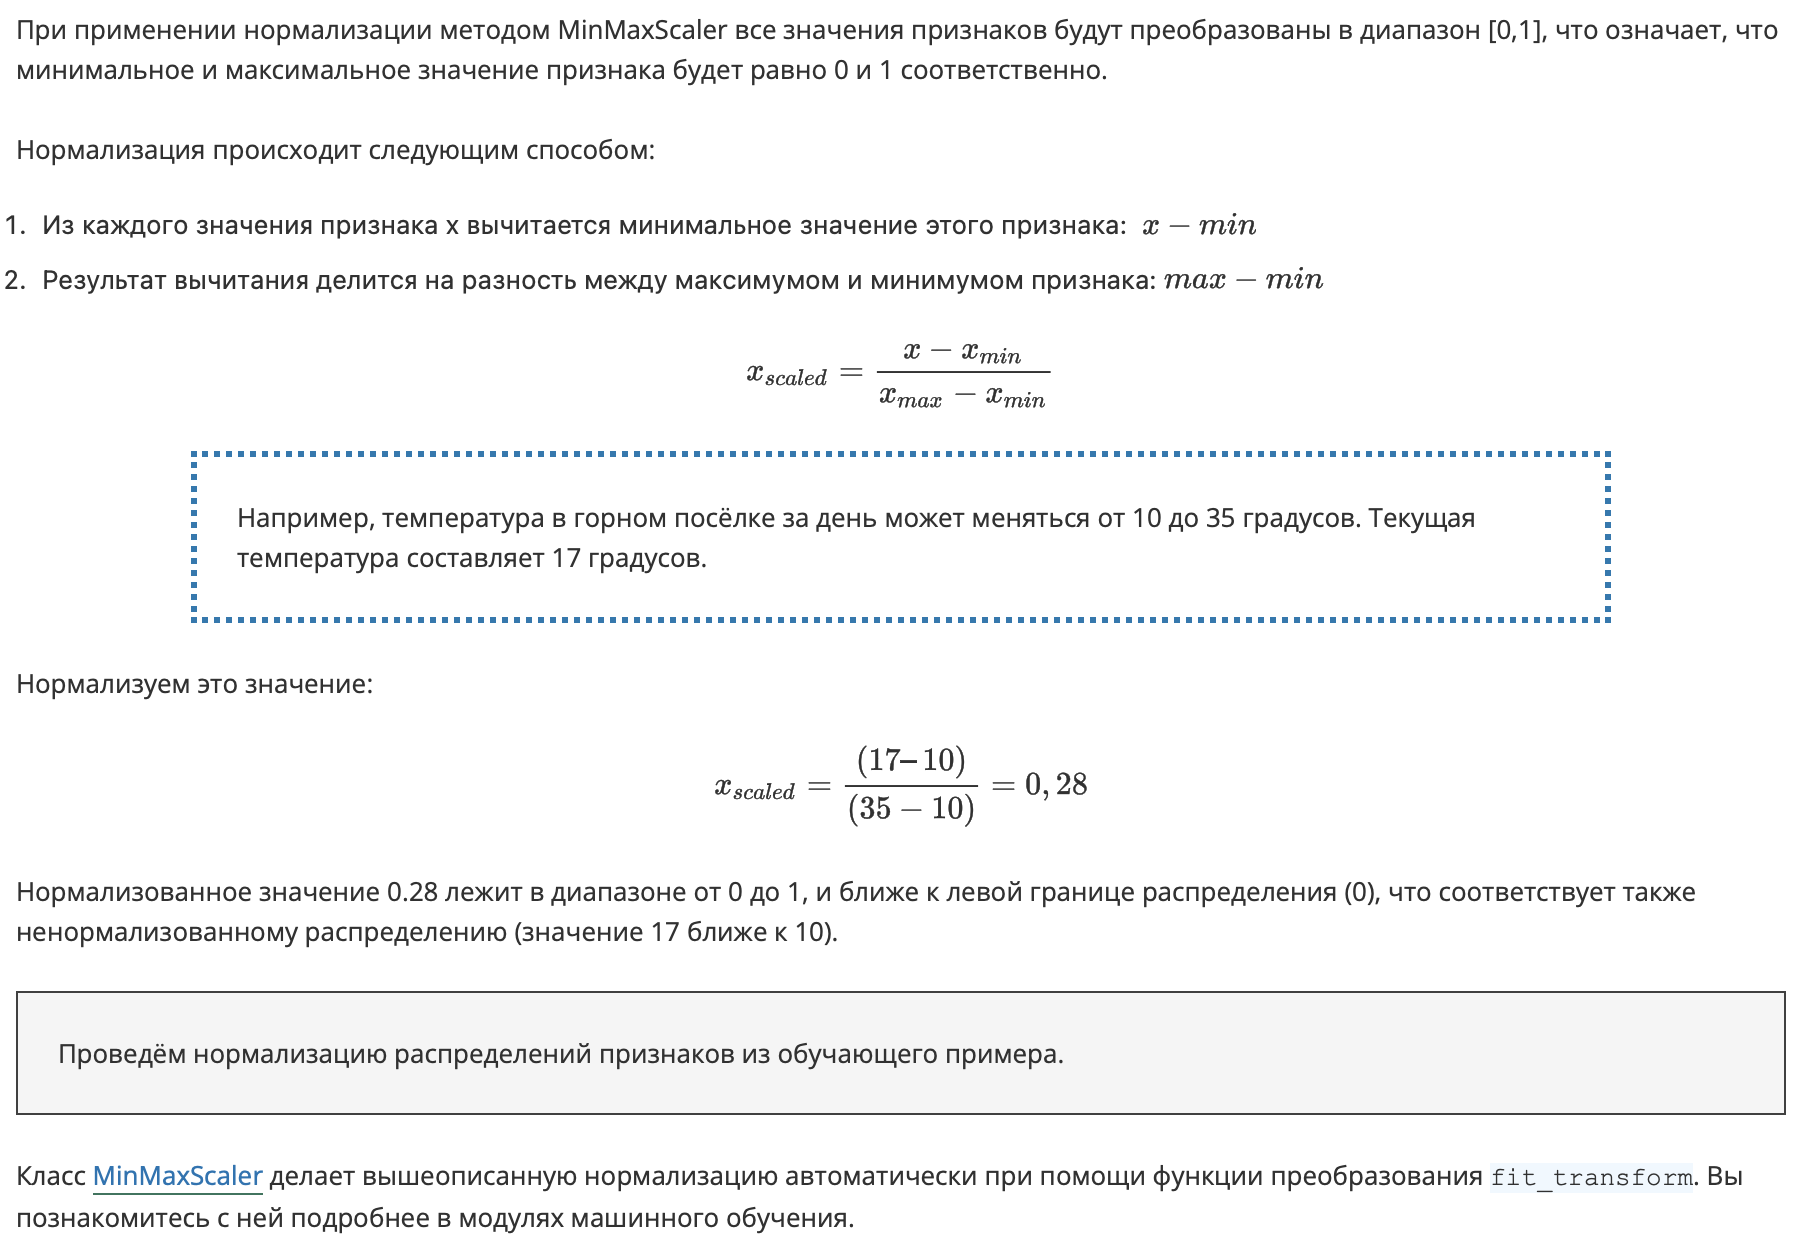

In [200]:
# инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()

# кодируем исходный датасет
df_mm = mm_scaler.fit_transform(df)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
df_mm = pd.DataFrame(df_mm, columns=col_names)

In [201]:
beta = df_mm['beta']
exponential = df_mm['exponential']
normal_p = df_mm['normal_p']
normal_l = df_mm['normal_l']
name_df_mm = [beta,exponential,normal_p,normal_l]
group_labels_mm = ['beta', 'exponential', 'normal_p', 'normal_l']
fig = ff.create_distplot(name_df_mm, group_labels_mm, show_hist=False)
fig.show()

Как мы видим, значения расположились в диапазоне от минимального 0 до максимального 1, как и должно произойти при таком способе нормализации. Также сохранилась форма исходного распределения: скошенные влево/вправо распределения сохранили свою форму.

Теперь рассмотрим нормализацию методом RobustScaler, а затем сравним их.

## ROBUSTSCALER

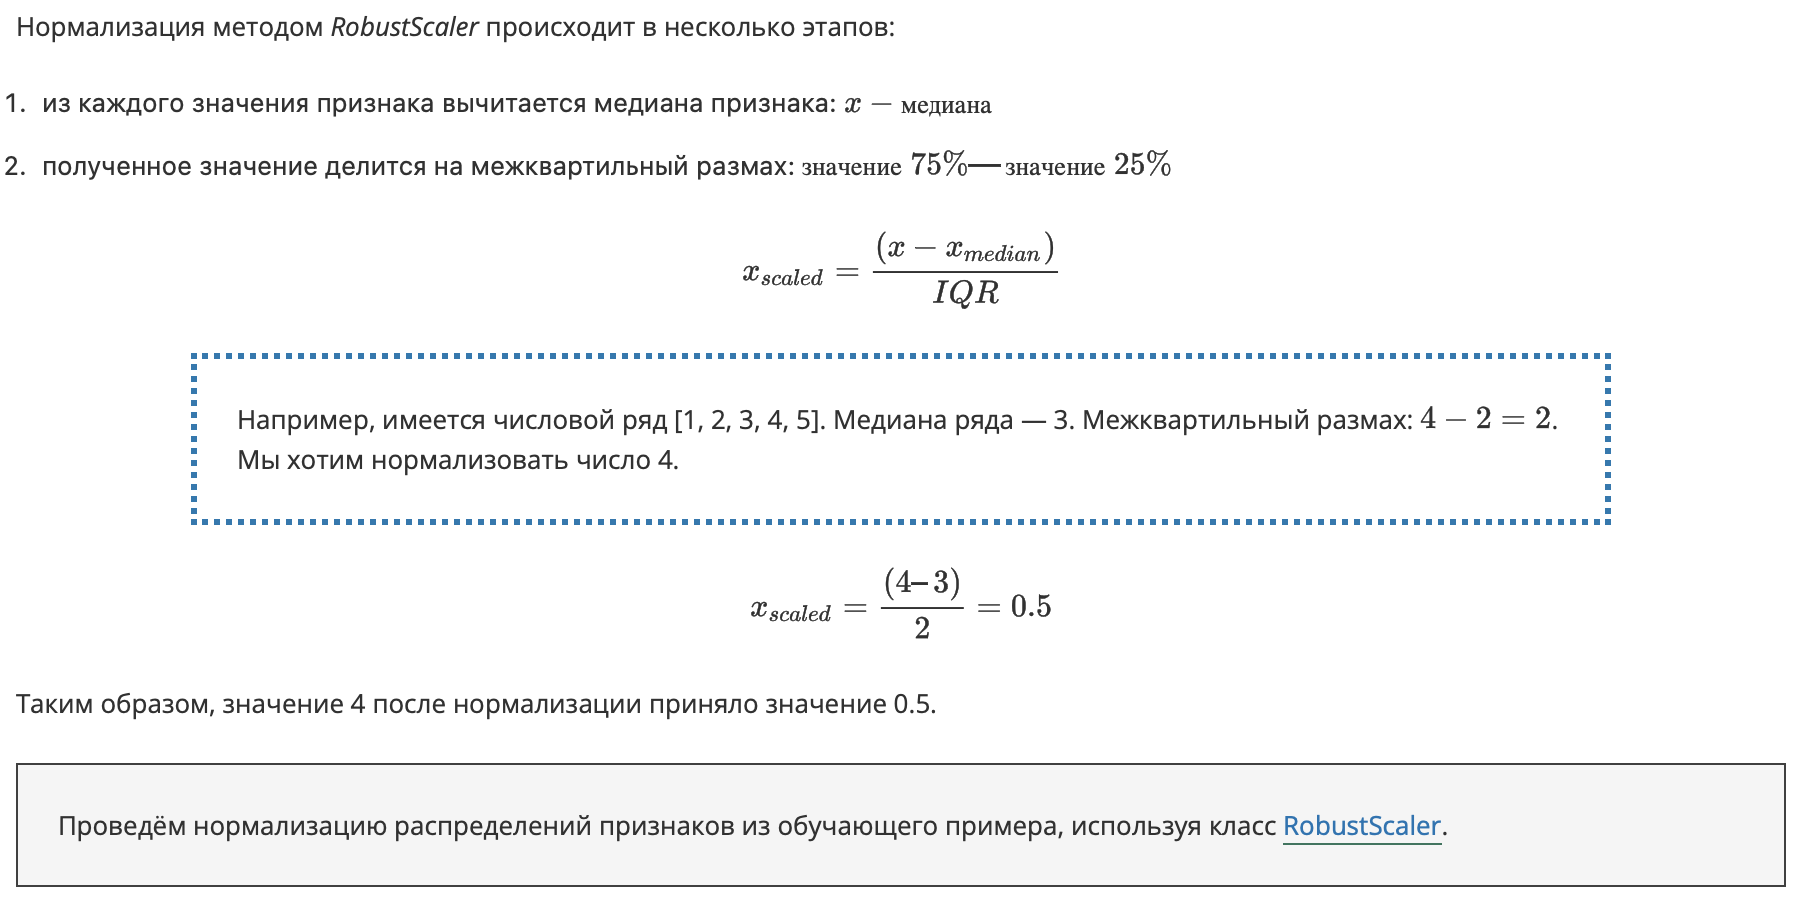

In [202]:
# инициализируем нормализатор RobustScaler
r_scaler = preprocessing.RobustScaler()

# кодируем исходный датасет
df_r = r_scaler.fit_transform(df)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
df_r = pd.DataFrame(df_r, columns=col_names)

In [203]:
beta = df_r['beta']
exponential = df_r['exponential']
normal_p = df_r['normal_p']
normal_l = df_r['normal_l']
name_df_r = [beta, exponential, normal_p, normal_l]
group_labels_r = ['beta', 'exponential', 'normal_p', 'normal_l']
fig = ff.create_distplot(name_df_r, group_labels_r, show_hist=False)
fig.show()

Из описательных статистик видно, что RobustScaler не масштабирует данные в заданный интервал, как делает это MinMaxScaler. Однако распределения не сохранили своё исходное состояние. Левый хвост экспоненциального распределения стал практически незаметным. То же произошло и с бета-распределением. Они стали более нормальными.

**В ЧЁМ РАЗНИЦА?**

Поскольку MinMaxScaler использует в своём вычислении минимальное и максимальное значения признака, то этот способ будет чувствителен к наличию выбросов в распределении.

RobustScaler в вычислении использует перцентили, и поэтому не зависит даже от большого количества выбросов.

Поэтому, если ваши данные уже были очищены от выбросов, смело используйте MinMaxScaler. Этот алгоритм нормализации используется специалистами по данным чаще всего в силу его простоты и понятности, а данные на этом этапе чаще всего уже очищены. Если вы пропустили этап очистки данных и нормализуете признаки раньше, используйте нормализатор RobustScaler.

Больше о других способах нормализации и их сравнении вы можете прочитать в официальном руководстве scikit-learn.



## СТАНДАРТИЗАЦИЯ

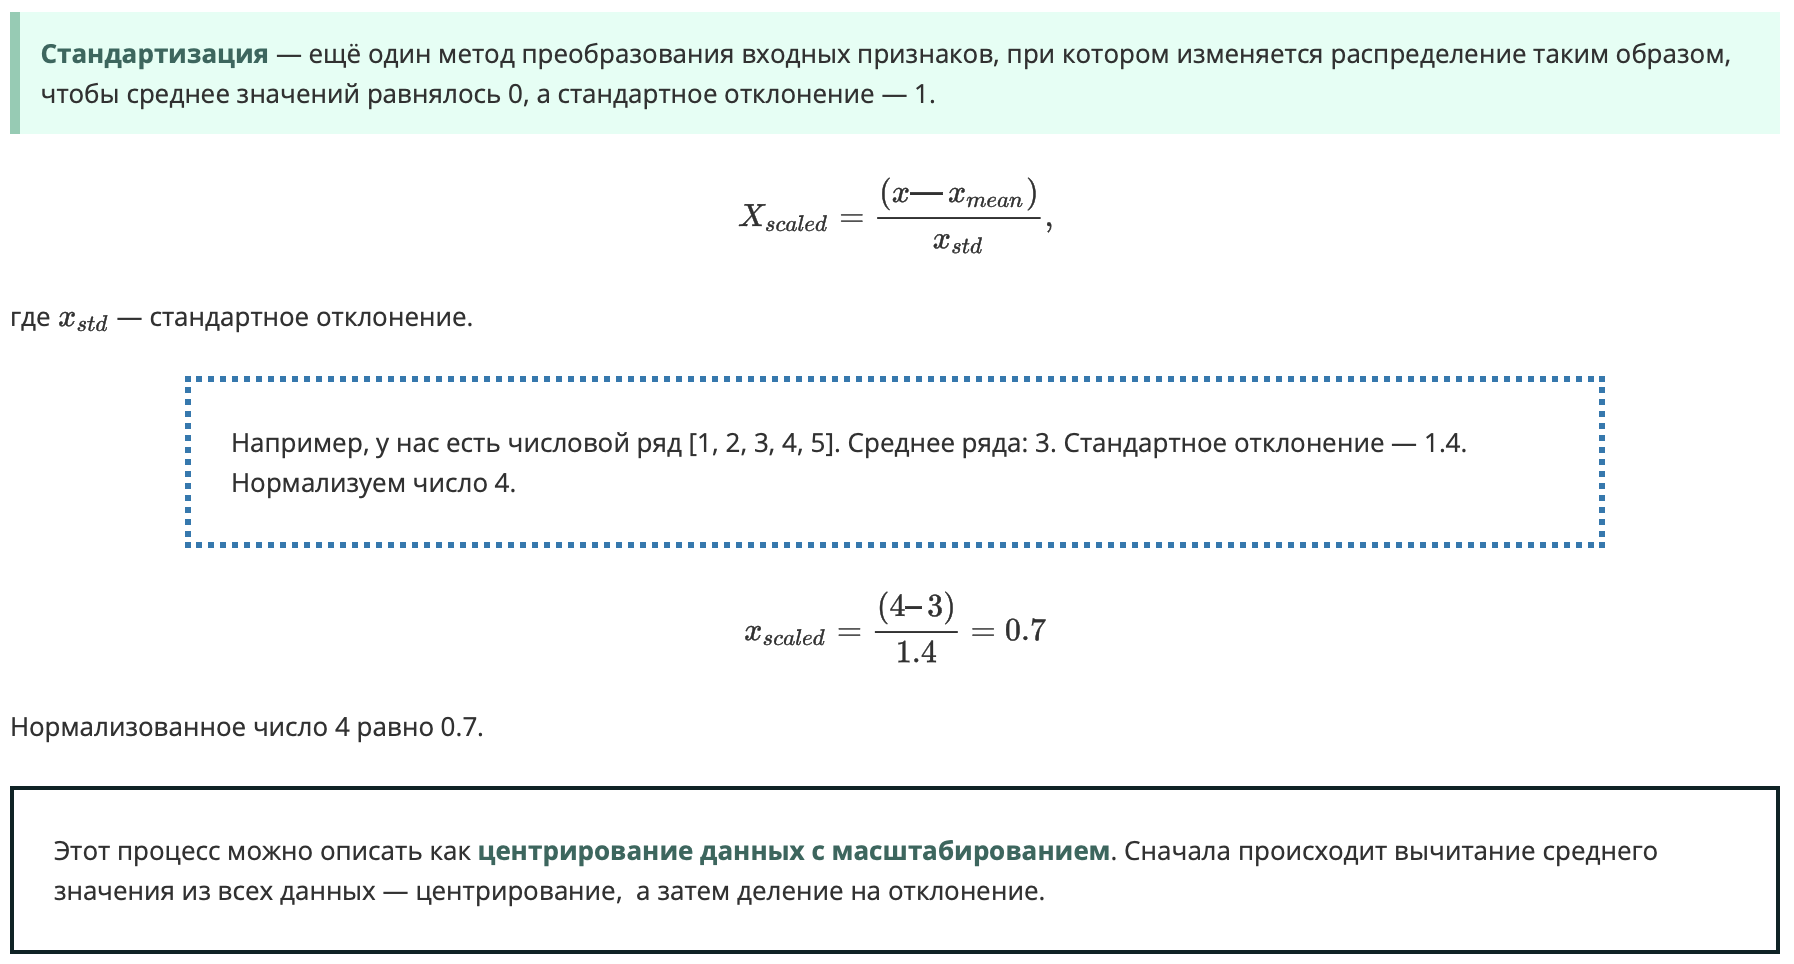

**ДЛЯ ЧЕГО НЕОБХОДИМО ТАКОЕ ПРЕОБРАЗОВАНИЕ?**

Как и нормализация, стандартизация может быть полезна при данных с разными масштабами. Однако в отличие от нормализации стандартизация предполагает, что признак распределён нормально.

Чтобы понять, как стандартизация меняет распределение, рассмотрим метод стандартизации StandardScaler в Python.

Продолжим использовать обучающий пример, сгенерированный нами при изучении нормализации данных. Стандартизируем признаки в исходном наборе данных.

Для стандартизации используем класс StandardScaler.

In [204]:
s_scaler = preprocessing.StandardScaler()

# кодируем исходный датасет
df_s = s_scaler.fit_transform(df)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
df_s = pd.DataFrame(df_s, columns=col_names)

In [205]:
beta = df_s['beta']
exponential = df_s['exponential']
normal_p = df_s['normal_p']
normal_l = df_s['normal_l']
name_df_s = [beta, exponential, normal_p, normal_l]
group_labels_s = ['beta', 'exponential', 'normal_p', 'normal_l']
fig = ff.create_distplot(name_df_s, group_labels_s, show_hist=False)
fig.show()

Стандартное отклонение стало равным 1, а средние значения — 0. Распределения изменились подобно RobustScaler — стали более нормальными.

**НОРМАЛИЗОВАТЬ ИЛИ СТАНДАРТИЗИРОВАТЬ?**

Так как ``нормализация`` и ``стандартизация`` преследуют одни и те же цели, возникают вопросы:

Когда признаки необходимо нормализовать, а когда стандартизировать? Какой способ нормализации выбрать? 

Преобразование входных переменных и выбор способа преобразования зависит от конкретной задачи и данных — заранее невозможно узнать, какое преобразования будет лучше. 

Однако мы составили небольшую инструкцию по преобразованию признаков:

* если признак распределён нормально, то его необходимо стандартизировать;
* если признак распределён ненормально, его необходимо нормализовать;
* если разброс значений небольшой, то можно обойтись без преобразования данных.

Выбор определённого способа преобразования и его необходимости может быть нелёгкой задачей, поэтому пробуйте делать различные преобразования и оценивайте результаты на конкретной модели, смотрите, есть ли разница в улучшении качества модели. О том, как сравнивать модели, вы узнаете далее в курсе в модулях про машинное обучение.

Что лучше? Нормализовать, а потом стандартизировать или наоборот?

Комбинации преобразований также могут быть эффективны. Поэтому проводите эксперименты над моделью и выбирайте то сочетание преобразований, которые обеспечивают лучший результат на ваших данных.

## Задание 6.4

Нормализуйте признак price. Выберите подходящий тип нормализации, учитывая тот факт, что в данных присутствуют вина с выбросной стоимостью.

В ответе напишите результат выполнения кода ``data['price'].sum()``, округлённый до целого.



In [206]:
wine_data = pd.read_csv('data/wine_cleared.csv')

In [207]:
scaler = preprocessing.RobustScaler()
wine_data['price'] = scaler.fit_transform(wine_data[['price']])
wine_data.head(3)

,Unnamed: 0,country,description,designation,points,price,province,region_1,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,0.334700,Sicily & Sardinia,Etna,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,-0.590909,Douro,unknown,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",unknown,87,-0.636364,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


In [208]:
wine_data['price'].sum()

43501.229482424984

## Задание 6.5

Стандартизируйте исходный признак price.

В ответе напишите результат выполнения кода ``data['price'][129968]``. Ответ округлите до сотых.

In [209]:
# инициализируем стандартизатор StandardScaler
standart_scaler = preprocessing.StandardScaler()
wine_data['price'] = standart_scaler.fit_transform(wine_data[['price']])
wine_data.head(3)

,Unnamed: 0,country,description,designation,points,price,province,region_1,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,6.171504e-17,Sicily & Sardinia,Etna,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,-5.145270e-01,Douro,unknown,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",unknown,87,-5.397942e-01,Oregon,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm


In [210]:
wine_data['price'][129968]

-0.13551812448719305